In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Lambda
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, matthews_corrcoef

# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

2023-06-19 07:43:50.918988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data
transactions = pd.read_csv('/Users/user/Documents/datasets/ieee/train_transaction.csv', index_col='TransactionID')
identity = pd.read_csv('/Users/user/Documents/datasets/ieee/train_identity.csv', index_col='TransactionID')
data = transactions.merge(identity, how='left', left_index=True, right_index=True)

In [3]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('isFraud', axis=1),
    data['isFraud'],
    test_size=0.2,
    random_state=42
)

In [4]:
# Data preprocessing
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
for col in categorical_cols:
    X_train[col] = X_train[col].fillna('unknown')
    X_test[col] = X_test[col].fillna('unknown')
    le = LabelEncoder()
    le.fit(list(X_train[col].values) + list(X_test[col].values))
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [5]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [6]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [7]:
# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
# Train a random forest classifier on the resampled training data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [9]:
# Make predictions on the testing data
y_pred = model.predict(X_test.fillna(0))

In [10]:
# Calculate the accuracy and other performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall

Accuracy: 0.9787736647813865
Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.88      0.48      0.62      4242

    accuracy                           0.98    118108
   macro avg       0.93      0.74      0.80    118108
weighted avg       0.98      0.98      0.98    118108

Confusion matrix:
[[113583    283]
 [  2224   2018]]


In [11]:
#predict the class probabilities
y_pred_proba = model.predict_proba(X_test.fillna(0))[:, 1]

In [12]:
#calculate the AUC value
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred_proba)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

F1-score:  0.616842427021244
Precision:  0.8770099956540635
Recall:  0.4757190004714757
Specificity:  0.9975146224509511
Sensitivity:  0.4757190004714757
AUC:  0.930977853833219


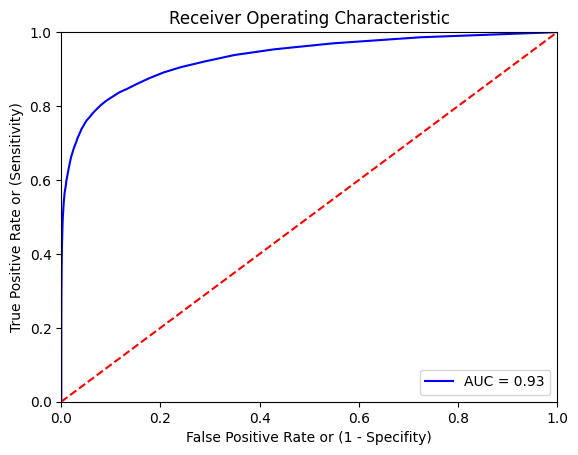

In [13]:
# calculate & plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1],'r--')#plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

Accuracy: 0.978774


In [15]:
mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews correlation coefficient:", mcc)

Matthews correlation coefficient: 0.6371361439590822
